## Solution of a Driven Damped Pendulum using a Kolmogorov-Arnold Network (KAN)

***Author: Brandon Ismalej (brandon.ismalej.671@my.csun.edu) - (https://github.com/Brandon-Ism)***

In [1]:
!pip install pykan torch numpy matplotlib scikit-learn tqdm sympy setuptools

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.2/74.2 kB 2.7 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import torch
import torch.nn as nn
from torch import autograd
from kan import KAN
import os

In [3]:
from sympy import symbols, Function
gamma_sym = symbols('gamma')
gamma_func = Function('gamma')

# Clear previous definitions
del gamma_sym
del gamma_func

In [4]:
# Initialize Constants
Omega_val = 2 * np.pi  
omega_val = Omega_val * 1.5 
lambda_val = omega_val / 2 
gamma_val = 0.8
omegaSQ_val = omega_val ** 2
f_val = gamma_val * omegaSQ_val

In [5]:
# Define the driven damped pendulum differential equation
def driven_damped_pendulum(t, y, omega, lambda_, gamma, Omega):
    theta, omega_dot = y
    dydt = [omega_dot, -lambda_ * omega_dot - omega**2 * np.sin(theta) + gamma * np.cos(Omega * t)]
    return dydt

# Initial conditions
y0 = [0.0, 0.0]

# Time points
t = np.linspace(0, 15, 15000)

# Solve the differential equation using solve_ivp
sol = solve_ivp(driven_damped_pendulum, [t[0], t[-1]], y0, args=(omega_val, lambda_val, gamma_val, Omega_val), t_eval=t, method='LSODA', rtol=1e-6, atol=1e-8)

In [6]:
# Save ODE solver results to CSV
ode_df = pd.DataFrame({'t': sol.t, 'theta': sol.y[0], 'omega_dot': sol.y[1]})
ode_df.to_csv('ode_solver_results.csv', index=False)


In [7]:
# Generate training data
x = torch.tensor(t, dtype=torch.float32).view(-1, 1)
y = torch.tensor(sol.y[0], dtype=torch.float32).view(-1, 1)
x_physics = torch.linspace(0, 15, 15000).view(-1,1).requires_grad_(True) # sample locations over the problem domain
x_boundary = torch.tensor([[0.0]]).requires_grad_(True)

In [8]:
print({type(x_physics)})

{<class 'torch.Tensor'>}


In [9]:
from kan import *
# Define the KAN model
physics_weight = 1e-3
model = KAN(width=[1,15,15,1], grid=5, k=3, seed=0)
#model = KAN(width=[1,10,1], grid=5, k=3, grid_eps=1.0) #noise scale base error after pykan updates
model.update_grid_from_samples(x_physics)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

In [10]:
# Convert to torch.Tensor
Omega = torch.tensor(Omega_val, dtype=torch.float32)
omega = torch.tensor(omega_val, dtype=torch.float32)
lambda_ = torch.tensor(lambda_val, dtype=torch.float32)
gamma = torch.tensor(gamma_val, dtype=torch.float32)  
omegaSQ = torch.tensor(omegaSQ_val, dtype=torch.float32)
f = torch.tensor(f_val, dtype=torch.float32)

In [11]:
# Training loop

epochs = 14500
losses = {'boundaryloss': [], 'physicsloss': [], 'totalloss': []}

for i in range(epochs):
    optimizer.zero_grad()
    
    # Compute the "physics loss"
    yhp = model(x_physics)
    dx  = torch.autograd.grad(yhp, x_physics, torch.ones_like(yhp), create_graph=True)[0] # computes dy/dx
    dx2 = torch.autograd.grad(dx, x_physics, torch.ones_like(dx), create_graph=True)[0]  # computes d^2y/dx^2
    physics = dx2 + lambda_ * dx + omega**2 * torch.sin(yhp) - gamma * torch.cos(Omega * x_physics)  # residual of the driven damped pendulum differential equation
    physicsloss = physics_weight * torch.mean(physics**2)
    
    # Compute the "boundary loss"
    y_boundary = model(x_boundary)
    dx_boundary = torch.autograd.grad(y_boundary, x_boundary, torch.ones_like(y_boundary), create_graph=True)[0]
    boundaryloss = torch.squeeze((y_boundary - 0.0)**2 + dx_boundary**2)
    
    # Combine losses
    loss = boundaryloss + physicsloss
    loss.backward()  # Backpropagation
    optimizer.step()  # Update parameters
    
    # Store losses
    losses['boundaryloss'].append(boundaryloss.detach().item())
    losses['physicsloss'].append(physicsloss.detach().item())
    losses['totalloss'].append(loss.detach().item())

    if (i+1) % 1000 == 0:
        print(f'Epoch [{i+1}/{epochs}], Total Loss: {loss.item():.4f}')

Epoch [1000/14500], Total Loss: 0.0004
Epoch [2000/14500], Total Loss: 0.0003
Epoch [3000/14500], Total Loss: 0.0003
Epoch [4000/14500], Total Loss: 0.0003
Epoch [5000/14500], Total Loss: 0.0002
Epoch [6000/14500], Total Loss: 0.0001
Epoch [7000/14500], Total Loss: 0.0009
Epoch [8000/14500], Total Loss: 0.0000
Epoch [9000/14500], Total Loss: 0.0000
Epoch [10000/14500], Total Loss: 0.0000
Epoch [11000/14500], Total Loss: 0.0000
Epoch [12000/14500], Total Loss: 0.0000
Epoch [13000/14500], Total Loss: 0.0000
Epoch [14000/14500], Total Loss: 0.0000


In [12]:
# Print final losses
print("\nFinal Losses:")
print(f"Boundary Loss: {losses['boundaryloss'][-1]:.4f}")
print(f"Physics Loss: {losses['physicsloss'][-1]:.4f}")
print(f"Total Loss: {losses['totalloss'][-1]:.4f}")


Final Losses:
Boundary Loss: 0.0000
Physics Loss: 0.0000
Total Loss: 0.0000


In [13]:
# Save KAN loss values to CSV
loss_df = pd.DataFrame(losses)
loss_df.to_csv('kan_loss_values.csv', index=False)


In [14]:
# Predict using the KAN model
x_test = torch.tensor(t, dtype=torch.float32).view(-1, 1)
y_kan = model(x_test).detach().numpy()

In [15]:
# Save KAN results to CSV
kan_df = pd.DataFrame({'t': t, 'theta': y_kan.squeeze()})
kan_df.to_csv('kan_results.csv', index=False)

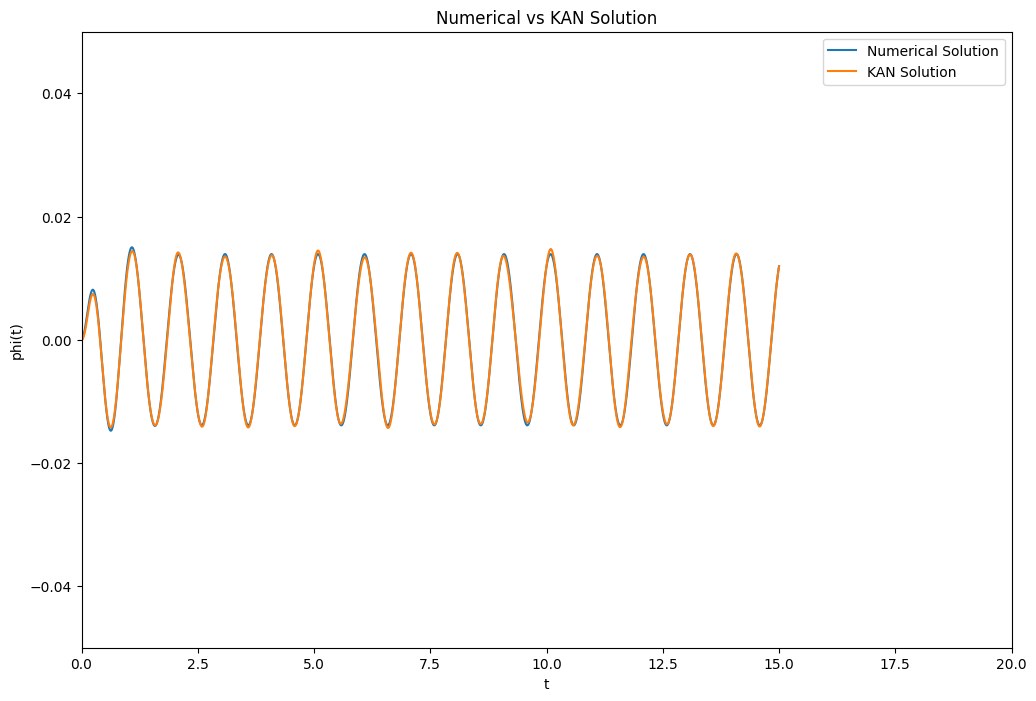

In [16]:
# Plot both the numerical and KAN solutions 
plt.figure(figsize=(12, 8))  
plt.plot(sol.t, sol.y[0], label='Numerical Solution')
plt.plot(t, y_kan, label='KAN Solution')
plt.xlabel('t')
plt.ylabel('phi(t)')
plt.legend()
plt.title('Numerical vs KAN Solution')

# limits for zooming in
plt.xlim(0, 20)  
plt.ylim(-0.05, 0.05)  

plt.savefig('/kaggle/working/KAN_0008.png')
plt.show()

In [17]:
# Plot the KAN grid

#model.plot()

In [18]:
# Try time up to 20
#